# Multiple choice test grading

In [1]:
from copy import deepcopy as copy
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

import matplotlib.pyplot as plt
import numpy             as np
import time

from skimage import exposure
import argparse
import imutils


import pytesseract as tes
from PIL import Image
from pytesseract import Output

C:\Users\irina\Anaconda3\envs\dev\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


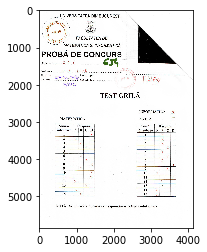

In [291]:
def read_scan(n,
              images_path ="exemple_corecte/",\
               file_name   ="image_%d.jpg",
              ):
    #Actual file name:
    file_name = file_name % n
    #Read image
    img = cv2.imread(images_path+file_name)
    return img

mock_scan = read_scan(6)
plt.imshow(mock_scan)

### Map official answers 

In [303]:
docs_path  = "barem/"
ground_truth = {}


for n in range(1, 5):
    file_name    = "Fizica_varianta%d.txt" %n
    m_ans        = np.zeros(15)
    p_ans        = np.zeros(15)
    i_ans        = np.zeros(15)
    
    for line in open(docs_path + file_name):
        row = line.split(" ") 
        
        if row[0] in "FR":
            continue
                
        if int(row[0]) < 16:
            m_ans[int(row[0]) - 1] = ord(row[1][:-1]) - ord('A')
            continue
            
        p_ans[int(row[0]) - 16]    = ord(row[1][:-1]) - ord('A')   
    
    file_name    = "Informatica_varianta%d.txt" %n
    for line in open(docs_path + file_name):
        row = line.split(" ") 
        
        if row[0] in "IR" or int(row[0]) in range(1, 16):
            continue 
        i_ans[int(row[0]) - 16]    = ord(row[1][:-1]) - ord('A')
            

    ground_truth["I%d" %n] = i_ans
    ground_truth["M%d" %n] = m_ans
    ground_truth["P%d" %n] = p_ans
    
ground_truth

{'I1': array([2., 0., 2., 3., 2., 1., 1., 2., 3., 3., 1., 3., 2., 2., 2.]),
 'M1': array([2., 3., 1., 2., 0., 2., 0., 3., 1., 0., 1., 2., 2., 3., 1.]),
 'P1': array([0., 2., 3., 0., 0., 0., 0., 3., 2., 3., 3., 2., 0., 0., 1.]),
 'I2': array([2., 3., 0., 3., 3., 0., 0., 1., 3., 3., 0., 2., 3., 2., 3.]),
 'M2': array([1., 3., 2., 0., 3., 0., 1., 1., 2., 0., 1., 2., 0., 1., 3.]),
 'P2': array([1., 1., 1., 1., 1., 3., 3., 3., 0., 2., 0., 1., 1., 0., 0.]),
 'I3': array([0., 1., 0., 0., 1., 0., 3., 3., 3., 0., 0., 0., 1., 1., 2.]),
 'M3': array([3., 0., 0., 1., 3., 0., 1., 3., 0., 2., 0., 2., 1., 3., 2.]),
 'P3': array([2., 0., 0., 2., 3., 2., 2., 2., 1., 0., 2., 1., 1., 2., 1.]),
 'I4': array([1., 1., 1., 2., 1., 0., 2., 2., 2., 1., 3., 1., 1., 0., 0.]),
 'M4': array([1., 0., 2., 3., 2., 1., 3., 3., 1., 3., 0., 0., 2., 2., 3.]),
 'P4': array([0., 2., 1., 3., 1., 3., 2., 1., 3., 3., 2., 3., 3., 3., 2.])}

### Extract grid portion from image 

https://stackoverflow.com/questions/42721213/python-opencv-extrapolating-the-largest-rectangle-off-of-a-set-of-contour-poin

In [3]:
def extract_grid(image):
    img = image[int(image.shape[1]/1.5):, :]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.blur(gray, (9, 9))
    img_th = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 201, 2)

    im, contours, hierarchy = cv2.findContours(img_th,
                                               cv2.RETR_CCOMP,
                                               cv2.CHAIN_APPROX_SIMPLE)
    # grids - first elem is for optional
    # second for Math
    grids = []
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    rects = sorted(rects, key=lambda r: r[0], reverse=True)
#     for cnt in contours:
    for rect in rects:
#         rect = cv2.boundingRect(cnt)
        x, y, w, h = rect
    #     if 100 < w < 10000 and w*h > 100000 and h < img.shape[0]:
        if w*h > 100000 and int(img.shape[0]/2) < h < img.shape[0]:

            y_ignore = int(h/17) * 2 # ignore first 2 lines
            x_ignore = int(w/6.8) * 3 # ignore first 3 columns
            croped_img = img[y + y_ignore:y + h , x + x_ignore:x + w]
    #         print(croped_img.shape[0], croped_img.shape[1])

#             y_additional_size = 15 - croped_img.shape[0] % 15
#             x_additional_size = 4 -  croped_img.shape[1] % 4    
    #         print('additional', y_additional_size, x_additional_size)

#             new_grid = np.zeros((croped_img.shape[0] + y_additional_size,croped_img.shape[1] + x_additional_size,3), np.uint8)
#             new_grid[:croped_img.shape[0], :croped_img.shape[1]] = croped_img
    #         print(new_grid.shape[0], new_grid.shape[1])

#             grids.append(new_grid)
            grids.append(croped_img)

    print("%d grids returned " \
                  %len(grids))
    return grids


True

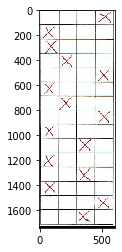

In [244]:
# plt.imshow(grids[0])
# cv2.imwrite("mock_grid_edit1.jpg", grids[0]) 

# plt.imshow(grids[1])
# cv2.imwrite("mock_grid_edit2.jpg", grids[1]) 

### Remove vertical and horizontal lines from extracted image

In [4]:
def remove_lines(original_grid):
    grid = cv2.cvtColor(original_grid, cv2.COLOR_BGR2GRAY)
    grid = cv2.threshold(grid, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]   
    
    grid = cv2.blur(grid, (9,9))
    
    # Create the images that will use to extract the horizontal and vertical lines
    horizontal = np.copy(grid)
    vertical   = np.copy(grid)

    cols = horizontal.shape[1]
    horizontal_size = cols // 5
    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
    horizontal = cv2.erode(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)

    # Specify size on vertical axis
    rows = vertical.shape[0]
    verticalsize = rows // 5
    # Create structure element for extracting vertical lines through morphology operations
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
    # Apply morphology operations
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)

    keep_vert          = np.where(vertical != 0)
    keep_horiz         = np.where(horizontal != 0)
    grid[keep_vert]    = 0 
    
#     plt.imshow(grid)
    grid[keep_horiz]   = 0 
    
    return grid

    

### Get aswers from grid

In [5]:
def get_answers(grid):
    boxes = []
    max_i = grid.shape[0] - (grid.shape[0] % 15)              #should be divisible with 15
    max_j = grid.shape[1] - (grid.shape[1] % 4)               #should be divisible with 4
    
    for row in np.split(grid[:max_i, :max_j], 15, axis=0):
        b_row = np.split(row, 4, axis=1)   
        boxes.append([box.sum() for box in b_row])

    norm_grid = np.array(boxes) / (np.array(boxes)).sum(axis=1)[:,None] 
    answers = np.argmax(norm_grid, axis=1)
    
    return answers


In [111]:
max_i, max_j, grids[0].shape[0] % 15, (grids[0].shape[1] % 4) 

(720, 252, 0, 0)

In [112]:
max_i = grids[0].shape[0] - (grids[0].shape[0] % 15)              #should be divisible with 15
max_j = grids[0].shape[1] - (grids[0].shape[1] % 4)               #should be divisible with 4
grids[0][:max_i, :max_j].shape, grids[0].shape

((720, 252, 3), (720, 252, 3))

### Calculate grading 

In [311]:
def score(math_answers, optional_answers):
    return ((math_answers + optional_answers) * 0.3) + 1

### Assign grade 

In [298]:
def assign_grade(image, optional,variant):
    start_time = time.time()
    grids = extract_grid(image)

    math_grid = remove_lines(grids[1])
    optional_grid = remove_lines(grids[0])

    answers_math = get_answers(math_grid)
    answers_optional = get_answers(optional_grid)

    grade = score((ground_truth["M%d" %variant] \
                   == answers_math).sum()\
                  , (ground_truth["%s%d" %(optional, variant)] \
                     == answers_optional).sum())

    end_time = time.time()
    print("%.2f grade returned in %.3f seconds." \
                  %(grade, end_time-start_time))

### 1. Grading a scan image

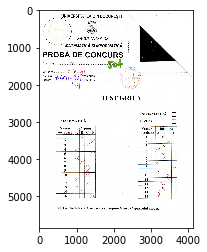

In [14]:
# image = read_scan(41)
plt.imshow(image)


In [292]:
images_path  = "test/"
n            =  215
file_name    = "image_%d.jpg" %n
# file_name    = "perspective_%d.jpg" %n
# file_name    = "rotation_%d.jpg" %n
image = cv2.imread(images_path + file_name) # trainImage

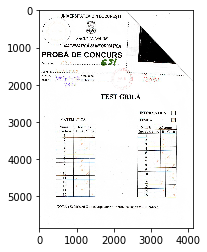

In [297]:
plt.imshow(image)


In [304]:
# start_time = time.time()
grids = extract_grid(image)

math_grid = remove_lines(grids[1])
optional_grid = remove_lines(grids[0])

answers_math = get_answers(math_grid)
answers_optional = get_answers(optional_grid)

# grade = score((ground_truth["M%d" %variant] \
#                == answers_math).sum()\
#               , (ground_truth["%s%d" %(optional, variant)] \
#                  == answers_optional).sum())



2 grids returned 


TypeError: 'list' object is not callable

In [305]:
answers_math

array([3, 1, 1, 2, 0, 0, 1, 1, 1, 2, 0, 2, 0, 2, 2], dtype=int64)

In [308]:
(ground_truth["M%d" %variant] \
               == answers_math).sum()

5

In [309]:
(ground_truth["M%d" %variant] \
               == answers_optional).sum()

3

In [310]:
answers_optional

array([3, 1, 1, 1, 1, 2, 0, 3, 2, 3, 3, 1, 3, 1, 3], dtype=int64)

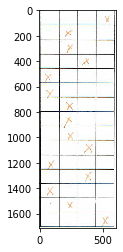

In [295]:
plt.imshow(grids[1])


In [299]:
variant = 2
optional = 'P'
assign_grade(image, optional, variant)

2 grids returned 


TypeError: 'list' object is not callable

### 2. Grading a transformed image

In [22]:
# image = cv2.imread('data/aligned_1.jpeg')
# variant = 1
# assign_grade(image, variant)

2 grids returned 
3.40 grade returned in 0.084 seconds.


In [312]:
images_path  = "test/"
n            =  215
file_name    = "image_%d.jpg" %n
# file_name    = "perspective_%d.jpg" %n
# file_name    = "rotation_%d.jpg" %n
image = cv2.imread(images_path + file_name) # trainImage

In [20]:
from __future__ import print_function
import cv2
import numpy as np
import time


 
MAX_FEATURES = 30000
GOOD_MATCH_PERCENT = 0.3

#good for rotatin no MAX_FEATURES and .3

def alignImages(im1, im2):
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    #Replace orb with sift
#     orb = cv2.xfeatures2d.SIFT_create(MAX_FEATURES)
    
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    
#     bf = cv2.BFMatcher()
#     matches = bf.knnMatch(descriptors1,descriptors2, k=2)
#     for m,n in matches:
#         if m.distance < .85 * n.distance:
#             good.append([m])
    
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2\
                                 , cv2.RANSAC\
                                 , ransacReprojThreshold=2)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h




In [318]:
start_time = time.time()
images_path  = "test/"
imReference = cv2.imread("template_test_grila.jpg")
n            =  215
#73#27, 61 is working 126 ok on rotation
#22 works on rotation and not on perspective;
#127 misses both;
#73 misses both;
#48 misses 2 x's on rotation and 5 on perspective 
# file_name    = "image_%d.jpg" %n
file_name    = "perspective_%d.jpg" %n
# file_name    = "rotation_%d.jpg" %n
img_to_transform = cv2.imread(images_path + file_name) # trainImage



print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(img_to_transform, imReference)

# Write aligned image to disk. 
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename); 
end_time = time.time()

cv2.imwrite(outFilename, imReg)

# Print estimated homography
print("Estimated homography in %.3f seconds: \n" \
      %(end_time - start_time)\
      , h)

Aligning images ...
Saving aligned image :  aligned.jpg
Estimated homography in 10.179 seconds: 
 [[ 9.88288873e-01  1.41459086e-02 -4.40123473e+02]
 [ 8.57475851e-02  1.34079615e+00 -8.46943698e+02]
 [-5.85807453e-06  1.62815449e-04  1.00000000e+00]]


2 grids returned 


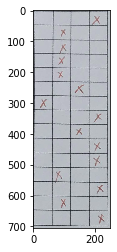

In [319]:
grids = extract_grid(imReg)
plt.imshow(grids[0])

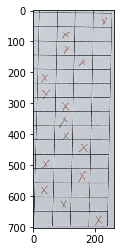

In [320]:
plt.imshow(grids[1])

In [321]:
variant  = 3
optional = 'P'
assign_grade(read_scan(n), optional, variant)

AttributeError: 'NoneType' object has no attribute 'shape'

In [322]:
variant = 2
optional = 'P'
assign_grade(imReg, optional, variant)

2 grids returned 
4.90 grade returned in 0.228 seconds.


### Real assigned grade

In [24]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 4
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Remove useless samples 
relevant_indexes = 0 < y_train
x_train = x_train[relevant_indexes]
y_train = y_train[relevant_indexes]
relevant_indexes = 5 > y_train
x_train = x_train[relevant_indexes]
y_train = y_train[relevant_indexes]-1

relevant_indexes = 0 < y_test
x_test = x_test[relevant_indexes]
y_test = y_test[relevant_indexes]
relevant_indexes = 5 > y_test
x_test = x_test[relevant_indexes]
y_test = y_test[relevant_indexes]-1



if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (24673, 28, 28, 1)
24673 train samples
4159 test samples





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 24673 samples, validate on 4159 samples
Epoch 1/4
24673/24673 [==============================] - 46s 2ms/step - loss: 0.1690 - acc: 0.9462 - val_loss: 0.0323 - val_acc: 0.9911
Epoch 2/4
24673/24673 [==============================] - 45s 2ms/step - loss: 0.0480 - acc: 0.9860 - val_loss: 0.0135 - val_acc: 0.9957
Epoch 3/4
24673/24673 [==============================] - 47s 2ms/step - loss: 0.0325 - acc: 0.9906 - val_loss: 0.0106 - val_acc: 0.9957
Epoch 4/4
24673/24673 [==============================] - 45s 2ms/step - loss: 0.0246 - acc: 0.9923 - val_loss: 0.0085 - val_acc: 0.9966
Test loss: 0.008486661542199502
Test accuracy: 0.9966338062034142


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy             as np
  

In [323]:
images_path  = "test/"
n            =  215
file_name    = "image_%d.jpg" %n
# file_name    = "perspective_%d.jpg" %n
# file_name    = "rotation_%d.jpg" %n
image = cv2.imread(images_path + file_name) # trainImage

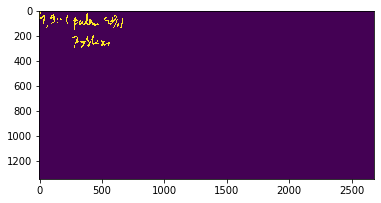

In [324]:
# Captures the live stream frame-by-frame 
#     _, frame = cap.read()  
frame = image

# Converts images from BGR to HSV 
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
sensitivity = 0

lower_red = np.array([170-sensitivity, 70, 50]) #red
upper_red = np.array([180-sensitivity, 255, 255]) #red

# Here we are defining range of redcolor in HSV 
# This creates a mask of red coloured  
# objects found in the frame. 
mask = cv2.inRange(hsv, lower_red, upper_red) 

# The bitwise and of the frame and mask is done so  
# that only the blue coloured objects are highlighted  
# and stored in res 
res = cv2.bitwise_and(frame,frame, mask= mask) 

res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
res = cv2.blur(res, (10, 10))
res = 255 - cv2.threshold(res, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]   

min_x, max_x = np.nonzero(res)[0].min(), np.nonzero(res)[0].max()
min_y, max_y = np.nonzero(res)[1].min(), np.nonzero(res)[1].max()

res = res[min_x:max_x, min_y:max_y]

cv2.imwrite("red.jpg", res)
plt.imshow(res)


In [330]:
img = copy(res)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.blur(img, (9, 9))
img_th = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 201, 2)

im, contours, hierarchy = cv2.findContours(img_th,
                                           cv2.RETR_CCOMP,
                                           cv2.CHAIN_APPROX_SIMPLE)


grids = []
for cnt in contours:
    rect = cv2.boundingRect(cnt)
    x, y, w, h = rect
    croped_img = img[y:y + h , x:x + w]
    grids.append(croped_img)


print("%d grids returned " \
              %len(grids))
# return grids
img1 = res.copy()

copyCon = contours[16:]
len(contours), len(copyCon)

18 grids returned 


(18, 2)

True

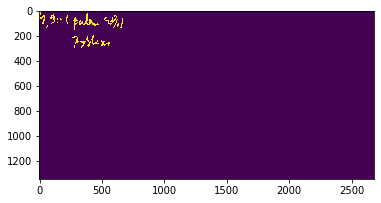

In [331]:
img1 = res.copy()
cv2.drawContours(img1,copyCon, -1, 255)
plt.imshow(img1)
cv2.imwrite("red.jpg", img1)


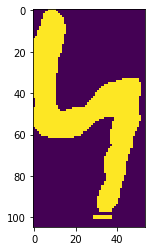

In [332]:
plt.imshow(grids[17])


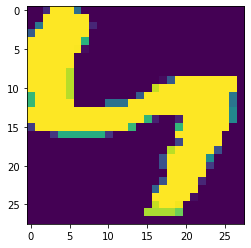

In [334]:
plt.imshow(cv2.resize(grids[17], (28, 28)))

In [336]:
mock_d = cv2.resize(grids[17], (28, 28))
mock_d = mock_d[None, :, :, None]
mock_d.shape

(1, 28, 28, 1)

In [337]:
model.predict(mock_d)[0],\
model.predict(mock_d)[0].argmax()+1

(array([0., 0., 0., 1.], dtype=float32), 4)